In [1]:
%load_ext autoreload
%autoreload 2

In [104]:
from pathlib import Path
import random

import torch
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import pytorch_lightning as pl
from torchinfo import summary

from utils import (plot_reach, plot_reconstruction_examples,
                   plot_grid_z, plot_data_in_latent_space, plot_dncnn_predictions)
from lin_ae_model_behavior import LinearVariationalAutoencoder

plt.rcParams['figure.dpi'] = 300

In [3]:
PATH_ROOT = Path('/Volumes/GoogleDrive/My Drive/NMA-22/naturalistic_arm_movements_ecog')
PATH_DATA = PATH_ROOT / 'data' / 'behavior_data'

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

DTYPE = torch.float
DEVICE = torch.device("mps")

DATASET = np.load(PATH_DATA / "reaches_scales.npy")
DATASET = np.swapaxes(DATASET, 2, 1)[:, :75, :]

PATH_ROI = PATH_ROOT / "data" / "Naturalistic reach ECoG tfrs ROI"
METADATA = pd.read_csv(PATH_ROI / "power-roi-all-patients-metadata.csv", index_col=0)

# check the dataset shape
assert DATASET.shape == (5984, 75, 2)

### Load trained model

In [4]:
chk_path = Path.cwd() / 'tb_logs' / 'LinearVariationalAutoencoder_n_latent=4_lr=0.005' / 'version_3' /'checkpoints' / 'last.ckpt'
model = LinearVariationalAutoencoder.load_from_checkpoint(chk_path, n_input=150, n_latent=4)



In [5]:
z_test = torch.tensor(np.array([[-1, 0, 0, 0]]), dtype=torch.float)

with torch.no_grad():
    sample = model.decoder(model.decoder_inp(z_test))

### Visualize DnCNN predictions

In [112]:
prediction = np.load(PATH_DATA / "DnCNN_prediction.npy")
prediction_ids = np.load(PATH_DATA / "DnCNN_prediction_data_ids.npy")
assert prediction.shape == (484, 4)
assert prediction_ids.shape == (484, )

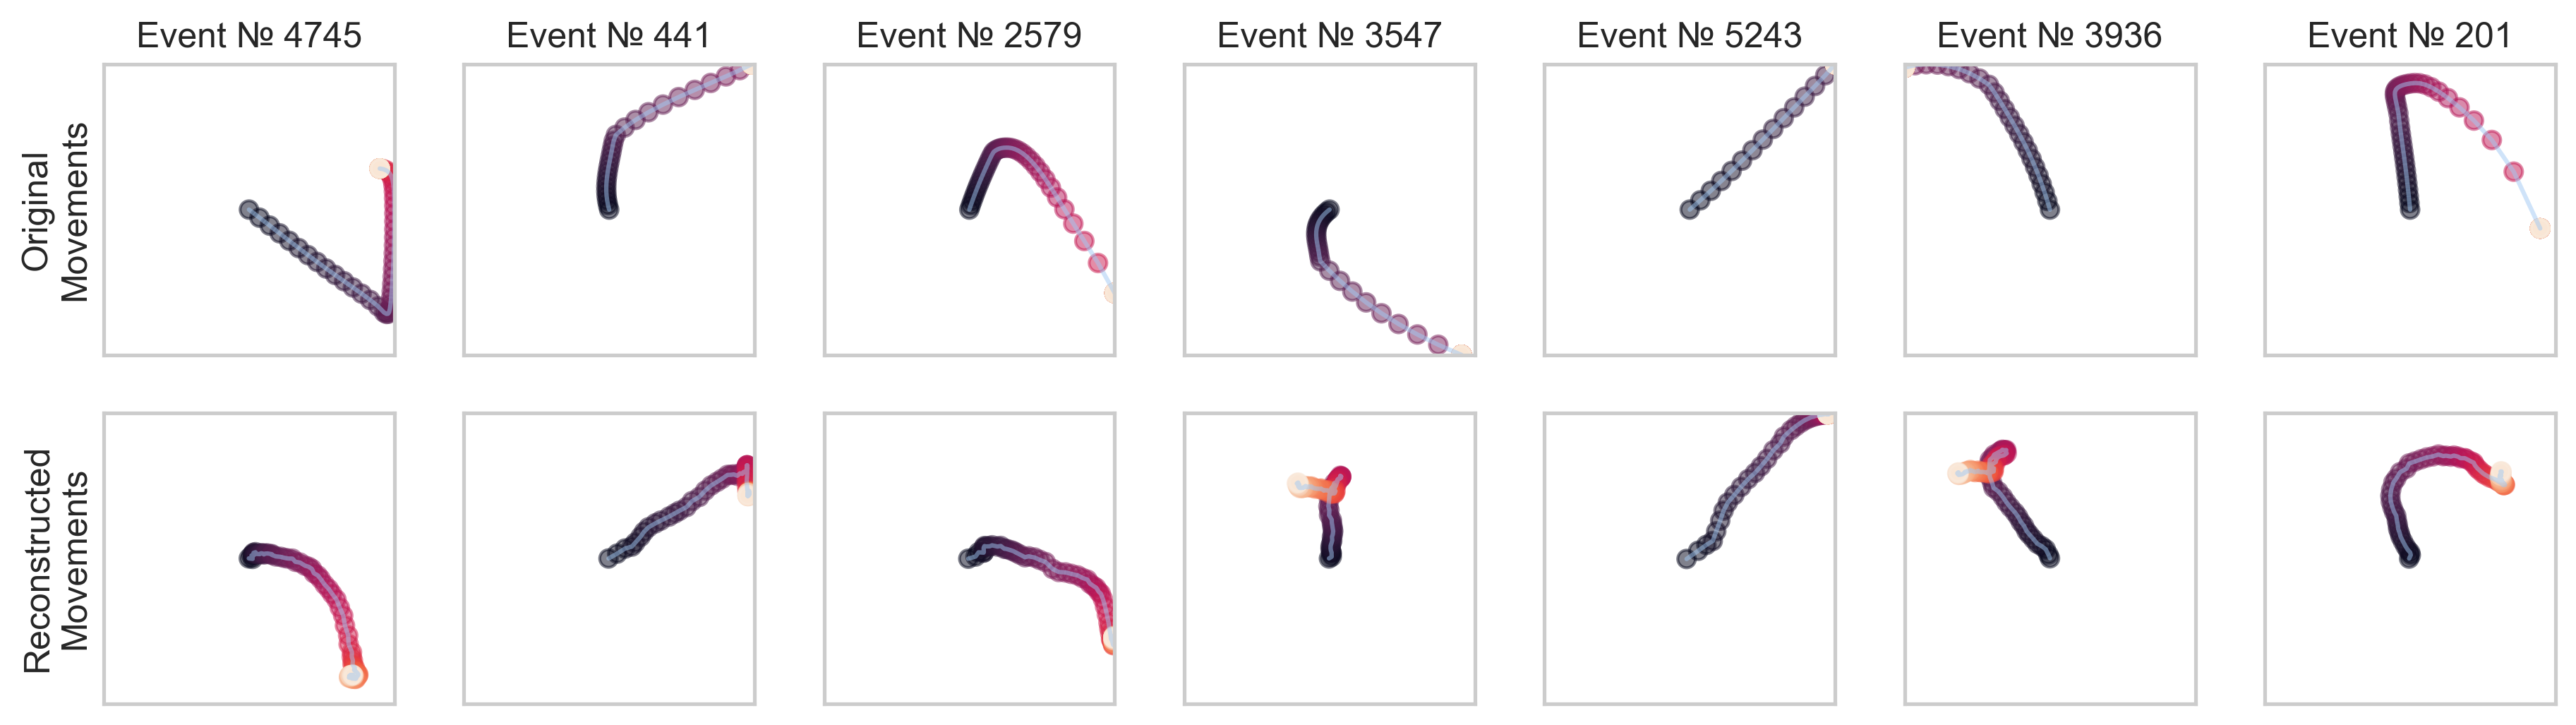

In [120]:
plot_dncnn_predictions(model, prediction, prediction_ids, DATASET, n_ex=7, events_to_plot=[4745, 441, 2579, 3547, 5243, 3936, 201]) # 

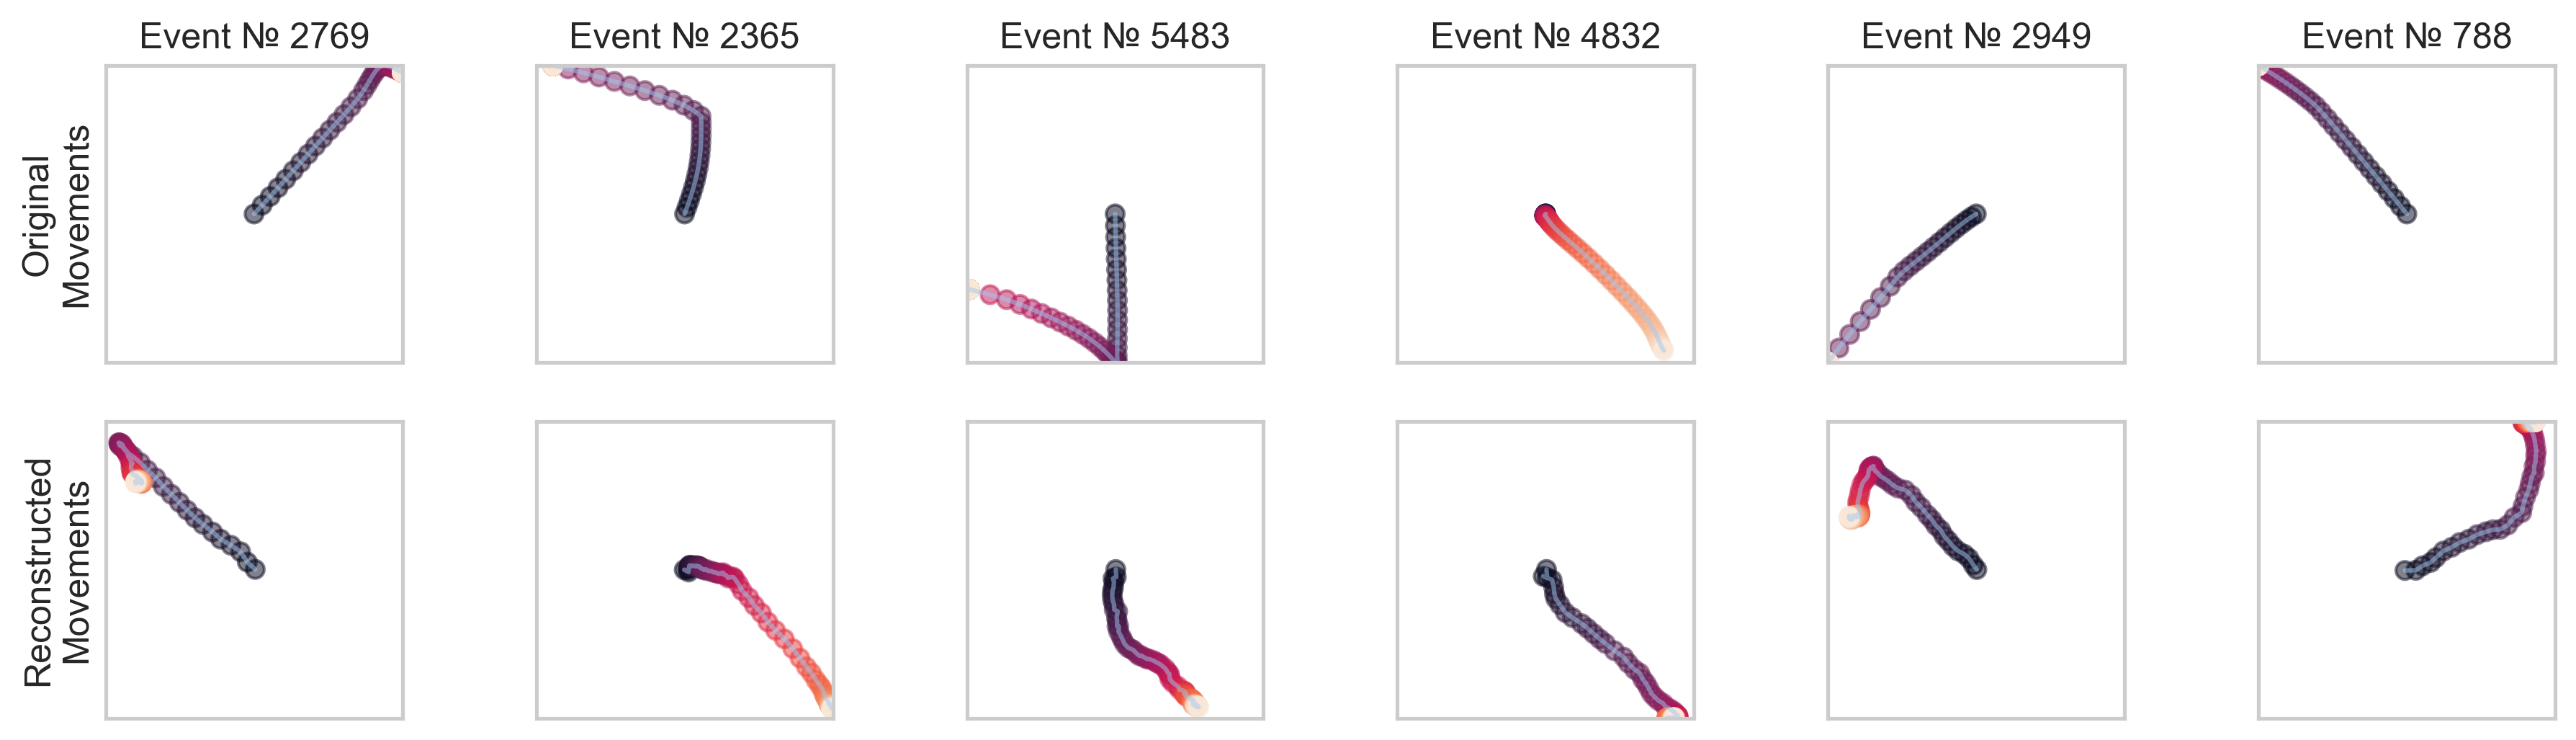

In [122]:
plot_dncnn_predictions(model, prediction, prediction_ids, DATASET, n_ex=6)

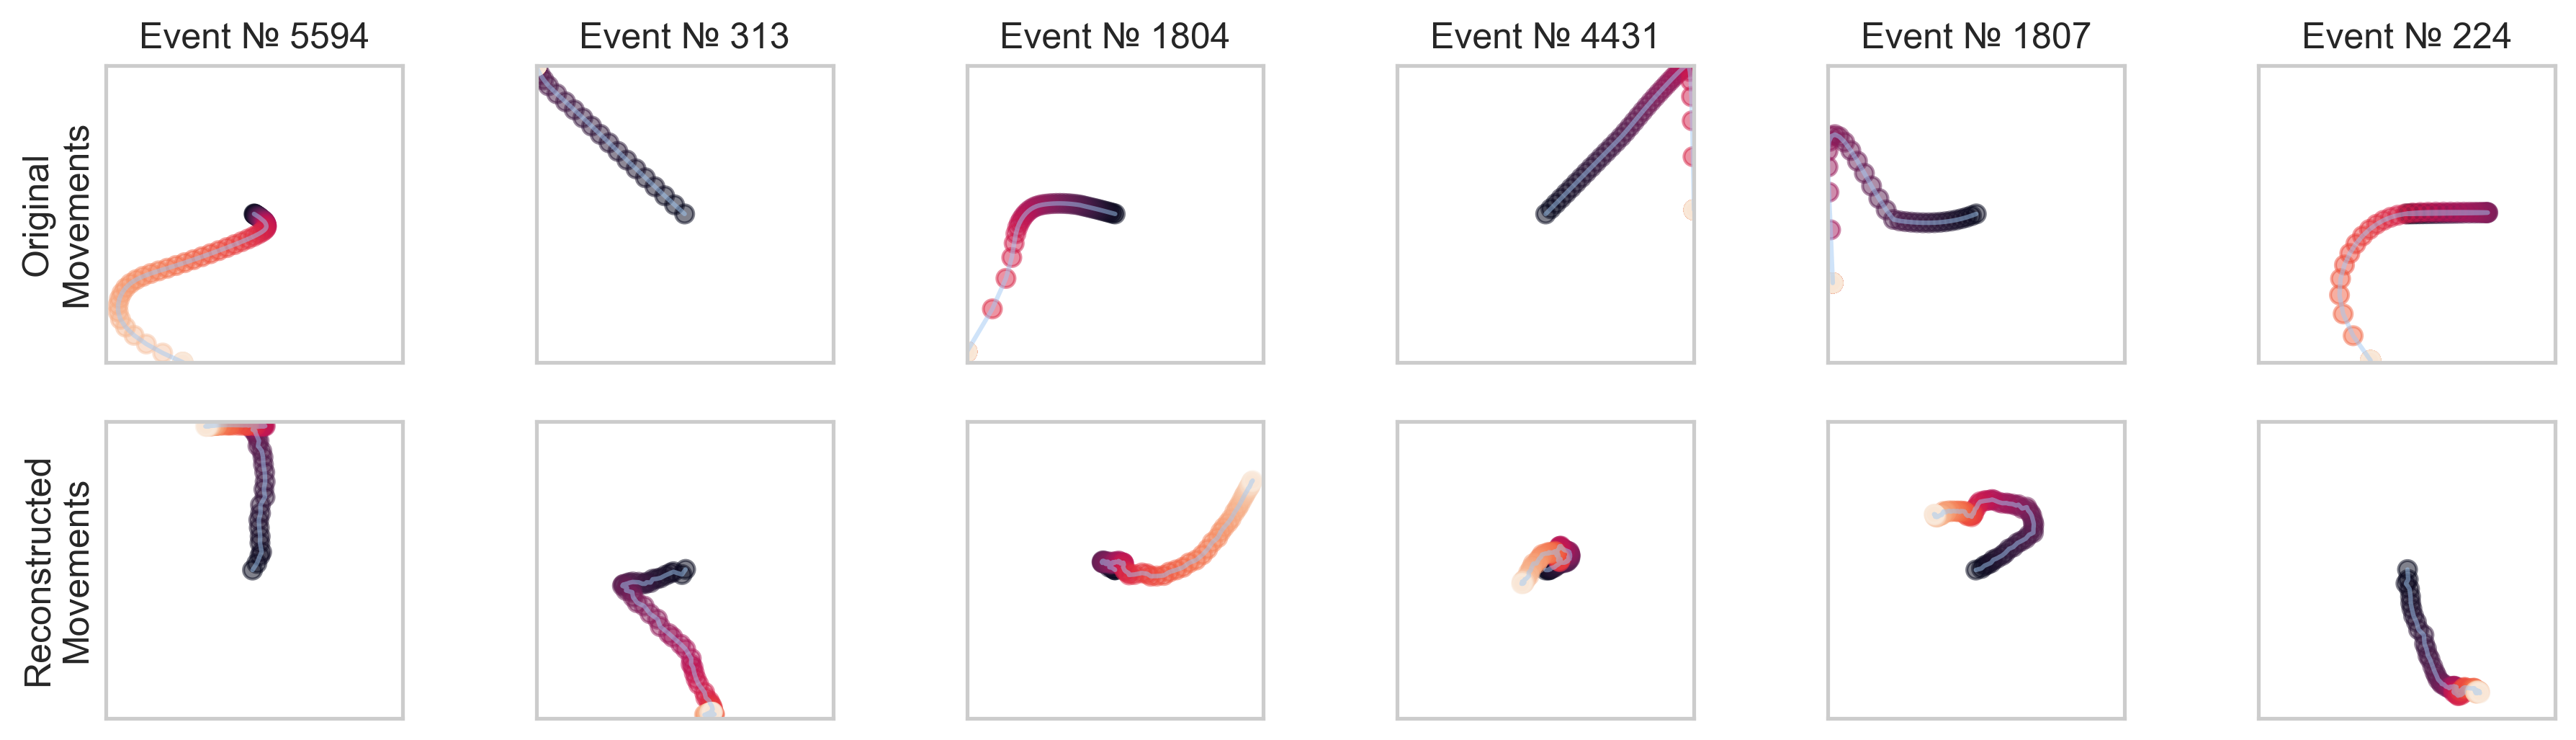

In [121]:
plot_dncnn_predictions(model, prediction, prediction_ids, DATASET, n_ex=6)

## Visualize latent space = 2

In [13]:
chk_path_2 = Path.cwd() / 'tb_logs' / 'LinearVariationalAutoencoder_n_latent=2_lr=0.005' / 'version_9' /'checkpoints' / 'last.ckpt'
model_2 = LinearVariationalAutoencoder.load_from_checkpoint(chk_path_2, n_input=150, n_latent=2)



In [ ]:
plot_grid_z(model_2, n_latent=2, z_ids=(0, 1), n_ex=7, max_z=10)

### Visualize z-values

In [47]:
import ipywidgets
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")
# sns.set_theme()

def plot_reaches_widget(z1, z2, z3, z4):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    z_ = torch.tensor(np.array([z1, z2, z3, z4]), 
                      device='cpu', dtype=torch.float)
    with torch.no_grad():
        sample = model.decoder(model.decoder_inp(z_))

    plot_reach(ax, torch.swapaxes(
        sample.reshape((2, 75)), 1, 0).unsqueeze(0), 0,
               plot_ticks_and_labels=True)
    ax.set_title('')
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    plt.show()


ipywidgets.interact(
    plot_reaches_widget, 
    z1=ipywidgets.FloatSlider(min=-3, max=3, step=0.2, value=0),
    z2=ipywidgets.FloatSlider(min=-3, max=3, step=0.2, value=0),
    z3=ipywidgets.FloatSlider(min=-3, max=3, step=0.2, value=0),
    z4=ipywidgets.FloatSlider(min=-3, max=3, step=0.2, value=0),
);

interactive(children=(FloatSlider(value=0.0, description='z1', max=3.0, min=-3.0, step=0.2), FloatSlider(value…

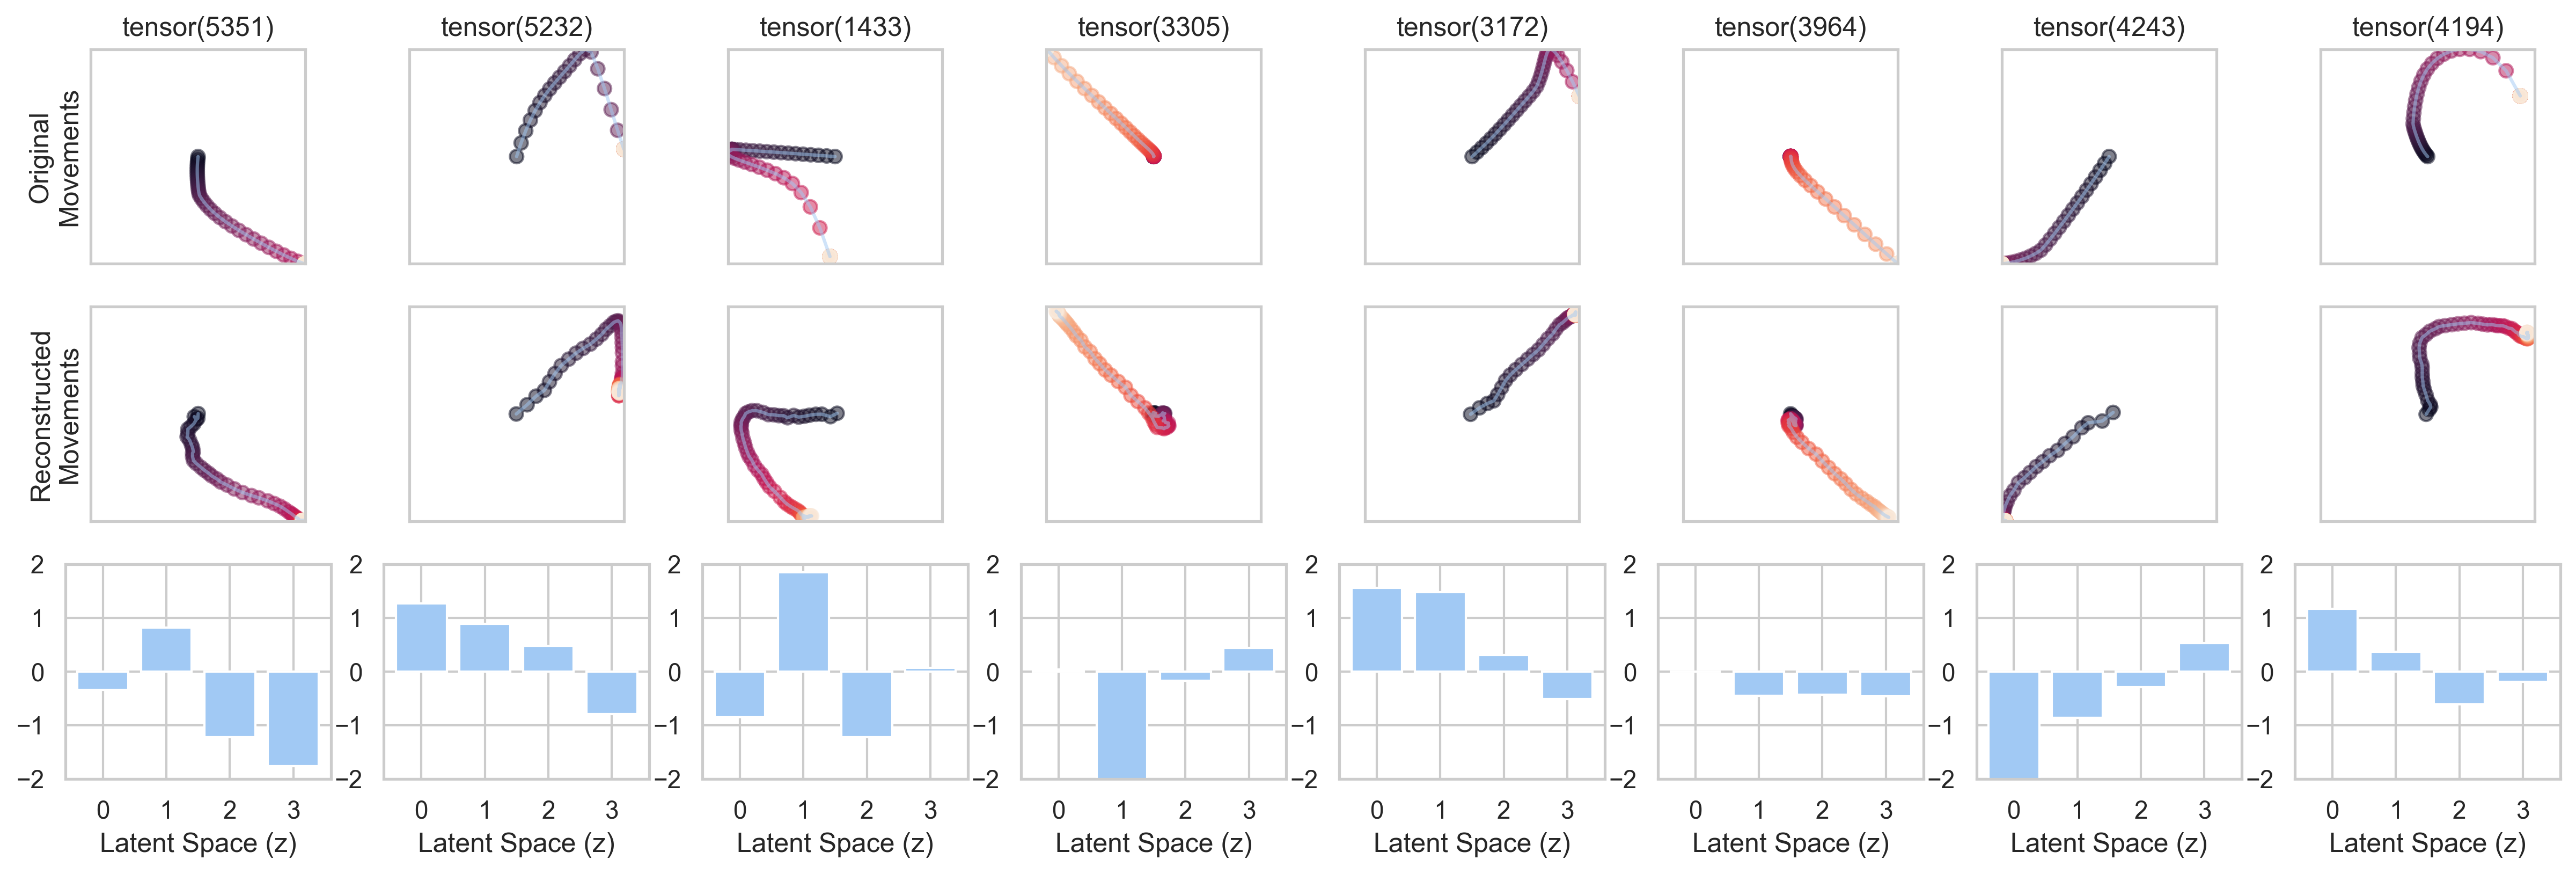

In [40]:
plot_reconstruction_examples(model, DATASET, 8, True)

In [ ]:
labels_4, z_4 = plot_data_in_latent_space(model, DATASET, 4, SEED)

In [16]:
def plot_reaches_widget(z1, z2):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    z_ = torch.tensor(np.array([z1, z2]), 
                      device='cpu', dtype=torch.float)
    with torch.no_grad():
        sample = model_2.decoder(model_2.decoder_inp(z_))

    plot_reach(ax, torch.swapaxes(
        sample.reshape((2, 75)), 1, 0).unsqueeze(0), 0,
               plot_ticks_and_labels=True)
    plt.show()


ipywidgets.interact(
    plot_reaches_widget, 
    z1=ipywidgets.FloatSlider(min=-3, max=3, step=0.2, value=0),
    z2=ipywidgets.FloatSlider(min=-3, max=3, step=0.2, value=0),
);

interactive(children=(FloatSlider(value=0.0, description='z1', max=3.0, min=-3.0, step=0.2), FloatSlider(value…

In [58]:
import ipywidgets

def plot_reaches_widget(event):
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_reach(ax, DATASET, event)
    ax.set_title('')
    plt.show();

ipywidgets.interact(
    plot_reaches_widget, event=ipywidgets.IntSlider(
    min=0, max=DATASET.shape[0]-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='event', max=5983), Output()), _dom_classes=('widget-inte…